This python notebook reads in features that have already been generated and saved to csv file.

In [1]:
import pandas as pd
import numpy as np
agg_data = pd.read_csv("../all_features.csv", low_memory=False)

In [2]:
import sys
print (sys.version)

3.6.0 |Anaconda 4.3.1 (x86_64)| (default, Dec 23 2016, 13:19:00) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


In [3]:
X = agg_data.drop(['ad_clicks', 'search_id'], axis = 1)  
X = X.drop(['num_weeknights', 'mys_feature_1_min', 'mys_feature_1_max'], axis = 1)  #remove feature that's highly correlated
y = (agg_data.ad_clicks > 0)
X = pd.get_dummies(X)
feature_names = list(X)
print(X.shape)
X.head(2)

(234105, 42)


,num_results,stay_duration,days_advance,historical_searches,log_historical_searches,historical_clicks,historical_sessions,device_pc,device_tablet,device_windows,...,dest_loc_es,dest_loc_fr,dest_loc_mx,dest_loc_de,has_dest_city,has_municipality,num_weekdays,prop_weekdays,mys_feature_1_mean,mys_feature_2
0,6,5,98,6,1.945910,0,0,True,False,True,...,False,False,False,False,True,False,4,0.666667,24.192920,102.651187
1,10,2,22,1,0.693147,0,0,True,False,False,...,False,False,False,False,True,False,0,0.000000,115.696186,23.976558


In [4]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold()
X = selector.fit_transform(X)   #this doesn't apply to any of the features
print(X.shape)

#setup train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

#preprocess data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

(234105, 42)


In [20]:
y_test.shape

(70232,)

In [5]:
pd.DataFrame(X_train_std, columns=feature_names).head()

,num_results,stay_duration,days_advance,historical_searches,log_historical_searches,historical_clicks,historical_sessions,device_pc,device_tablet,device_windows,...,dest_loc_es,dest_loc_fr,dest_loc_mx,dest_loc_de,has_dest_city,has_municipality,num_weekdays,prop_weekdays,mys_feature_1_mean,mys_feature_2
0,1.310792,-0.004104,-0.309658,-0.081374,-0.478560,-0.051361,-0.254846,0.462932,-0.443424,-1.376878,...,8.274488,-0.092927,-0.139406,-0.074396,0.470485,-0.322717,-0.003822,0.520956,0.812792,-0.023600
1,-0.634439,0.003819,-0.563101,-0.081374,-0.478560,-0.051361,0.177142,-2.160146,2.255177,-1.376878,...,-0.120853,-0.092927,-0.139406,-0.074396,0.470485,-0.322717,0.004101,0.687046,-0.614234,-0.030905
2,-0.634439,0.003819,-0.563101,-0.086090,-1.015550,-0.051361,-0.254846,0.462932,-0.443424,-1.376878,...,-0.120853,-0.092927,-0.139406,-0.074396,-2.125467,-0.322717,0.004101,0.687046,-0.023220,-0.031484
3,-0.310234,-0.010896,-0.436379,-0.020074,1.082413,0.111303,0.609130,0.462932,-0.443424,0.726281,...,-0.120853,-0.092927,-0.139406,-0.074396,0.470485,-0.322717,-0.011746,-1.970388,-0.989844,-0.038232
4,-0.958644,0.003819,-0.563101,-0.086090,-1.015550,-0.051361,-0.254846,0.462932,-0.443424,-1.376878,...,-0.120853,-0.092927,-0.139406,-0.074396,-2.125467,-0.322717,0.004101,0.687046,-1.584085,-0.031487


In [6]:
y_train.head()

212448    False
77657     False
39125     False
81058      True
137439    False
Name: ad_clicks, dtype: bool

In [7]:
collected_values = []
df_x = pd.DataFrame(X)
names = feature_names
for i in range(len(names)):
    if i % 10 == 0:    # is even
        print(i)
    for j in range(len(names)):
        if i==j:
            collected_values.append([names[i], names[j], 1])
        else:
            c = df_x[[i, j]].corr().iloc[0,1].item()      #get correlation between the two variables
            collected_values.append([names[i], names[j], c])  

0
10
20
30
40


In [8]:
cor_df = pd.DataFrame(collected_values, columns=['var1', 'var2', 'correlation'])
cor_df = cor_df.pivot("var1", "var2", "correlation")
cor_df.to_csv("feature_correlation.csv", index=False)

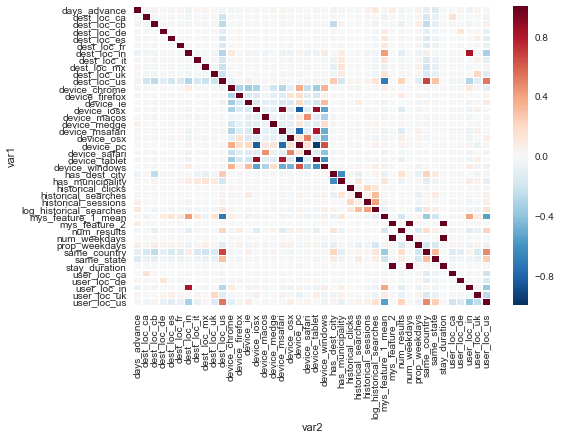

In [9]:
%matplotlib inline
import seaborn as sns
sns.set()
sns.heatmap(cor_df.iloc[0:len(names), 0:len(names)],  linewidths=.5)

In [10]:
# the Perceptron model doesn't work if the data is not perfectly linearly separable
#also, it cannot be plotted
from sklearn.linear_model import Perceptron
ppn = Perceptron(n_iter=100, eta0=0.1, random_state = 0)
ppn.fit(X_train_std, y_train)
y_pred = ppn.predict(X_test_std)

print(y_test[0:5].values)
print(y_pred[0:5])

from sklearn.metrics import accuracy_score
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

[ True  True  True False  True]
[ True False False  True  True]
Accuracy: 0.648


In [11]:
#logistic regression to predict class probabilities
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C = 0.1, random_state = 0)
lr.fit(X_train_std, y_train)
y_pred_prob = lr.predict_proba(X_test_std)
y_pred = lr.predict(X_test_std)
print(y_test[0:5].values)
print(y_pred[0:5])
print(y_pred_prob[0:5])

from sklearn.metrics import accuracy_score, precision_score, recall_score
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

[ True  True  True False  True]
[ True False  True  True  True]
[[  3.62431899e-01   6.37568101e-01]
 [  6.59084977e-01   3.40915023e-01]
 [  1.07042038e-01   8.92957962e-01]
 [  4.66803063e-01   5.33196937e-01]
 [  7.39491592e-06   9.99992605e-01]]
Accuracy: 0.716


#support vector machines
from sklearn.svm import SVC
svm = SVC(kernel='rbf', C=1.0, gamma=0.0002, random_state = 0)
svm.fit(X_train_std, y_train)
y_pred = svm.predict(X_test_std)

from sklearn.metrics import accuracy_score, precision_score, recall_score
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

In [8]:
#decision tree
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, random_state = 0)
tree.fit(X_train_std, y_train)
y_pred = tree.predict(X_test_std)
print(y_test[0:5].values)
print(y_pred[0:5])

from sklearn.metrics import accuracy_score
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

[ True  True  True False  True]
[ True  True  True False  True]
Accuracy: 0.762


In [9]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(criterion = 'entropy', n_estimators = 25,n_jobs =2,
                               random_state =0)
forest.fit(X_train_std, y_train)
y_pred = forest.predict(X_test_std)
y_pred_prob = forest.predict_proba(X_test_std)

from sklearn.metrics import accuracy_score
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.820


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 7, p=2, metric = 'minkowski')
knn.fit(X_train_std, y_train)
y_pred = knn.predict(X_test_std)

from sklearn.metrics import accuracy_score, precision_score, recall_score
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = None, random_state=0)
ada = AdaBoostClassifier(base_estimator = tree, n_estimators = 5000, learning_rate = 10.0,
                        random_state = 0)

tree.fit(X_train_std, y_train)
y_pred = tree.predict(X_test_std)
print(y_test[0:5].values)
print(y_pred[0:5])

from sklearn.metrics import accuracy_score
print('Tree Accuracy: %.3f' % accuracy_score(y_test, y_pred))

ada.fit(X_train_std, y_train)
y_pred = ada.predict(X_test_std)

print(y_test[0:5].values)
print(y_pred[0:5])

from sklearn.metrics import accuracy_score
print('Adaboost Accuracy: %.3f' % accuracy_score(y_test, y_pred))

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
boost = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, random_state=0)
boost.fit(X_train_std, y_train)
y_pred = boost.predict(X_test_std)
y_pred_gbc = y_pred
y_pred_prob = boost.predict_proba(X_test_std)

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('precision_score: %.3f' % precision_score(y_test, y_pred))
print('recall_score: %.3f' % recall_score(y_test, y_pred))
print(len(y_test))
pd.DataFrame(confusion_matrix(y_test, y_pred))
#col represents predictions
#row represents actual

Accuracy: 0.792
precision_score: 0.760
recall_score: 0.868
70232


,0,1
0,24488,9848
1,4740,31156


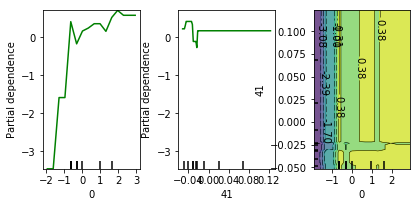

In [16]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.ensemble.partial_dependence import plot_partial_dependence
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                 max_depth=1, random_state=0).fit(X_train_std, y_train)
features = [0, 41, (0, 41)]

width = 20
height = 12
plt.figure(figsize=(width, height))

fig, axs = plot_partial_dependence(clf, X_train_std, features, label=2) 

In [10]:
print(len(clf.feature_importances_))
print(len(feature_names))
print(1.0/len(clf.feature_importances_ ))

d = {'importance': clf.feature_importances_,
     'feature_names': feature_names}
df = pd.DataFrame(d).sort_values('importance', ascending=False)
df[['indexed_importance']] = df[['importance']]/(1.0/len(clf.feature_importances_ ))
df.head(10)

42
42
0.023809523809523808


,feature_names,importance,indexed_importance
0,num_results,0.17,7.14
41,mys_feature_2,0.15,6.30
1,stay_duration,0.10,4.20
3,historical_searches,0.09,3.78
2,days_advance,0.05,2.10
16,device_msafari,0.05,2.10
4,log_historical_searches,0.05,2.10
5,historical_clicks,0.03,1.26
8,device_tablet,0.03,1.26
19,same_country,0.03,1.26


In [ ]:
#an ensemble- classification with majority vote?
from sklearn.ensemble import VotingClassifier
estimators = []
model1 = LogisticRegression(C = 0.1, random_state = 0)
estimators.append(('logistic', model1))
model2 = GradientBoostingClassifier(n_estimators=100, random_state = 0)
estimators.append(('cart', model2))
model3 = SVC(kernel='rbf', C=1.0, gamma=0.0002, random_state = 0)
estimators.append(('svm', model3))
# create the ensemble model
ensemble = VotingClassifier(estimators)

y_pred = [c.fit(X_train_std, y_train).predict(X_test_std) for c in (model1, model2, model3, ensemble)]

from sklearn.metrics import accuracy_score
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred[3]))